In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1, 28, 28, 1])

# Helper functions

We will initialise the weights to have a small amount of noise to break symmetry and to prevent 0 gradients.

In [5]:
# Helper functions
def weight_v(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_v(shape):
    initial = tf.constant(0.1, shape = shape)
    return initial

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding='SAME')

# Model

The first convolution will compute 32 features for each 5x5 patch.

In [6]:
# First Convolution layer
with tf.name_scope("Conv1"):
    W_conv1 = weight_v([5, 5, 1, 32])
    b_conv1 = bias_v([32])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

The second convolution will comput 64 features for each 5x5 patch.

In [7]:
# Second Conv layer
with tf.name_scope("Conv2"):
    W_conv2 = weight_v([5, 5, 32, 64])
    b_conv2 = bias_v([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

Densely connected layer for our classifying decision.

In [8]:
with tf.name_scope("fc1"):
    W_fc1 = weight_v([7 * 7 * 64, 1024])
    b_fc1 = bias_v([1024])

    h_image_flatten = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_image_flatten, W_fc1) + b_fc1)

In [9]:
with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [10]:
with tf.name_scope("fc2"):
    W_fc2 = weight_v([1024, 10])
    b_fc2 = bias_v([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Training (This takes a while,  > 30 mins?)

In [15]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_true: batch[1], keep_prob: 1})
            plt.scatter(i,train_accuracy)
            #print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_true: batch[1], keep_prob: 0.8})
    final_test_error = accuracy.eval(feed_dict={x: mnist.test.images, y_true: mnist.test.labels, keep_prob: 1.0})

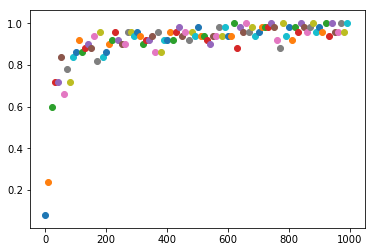

In [16]:
plt.show()